In [1]:
import numpy as np
import pandas as pd
from scipy.io import loadmat, wavfile
from hmmlearn import hmm
import librosa

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os

In [17]:
speaker_info = {'03': ('m', 31), '08': ('f', 34), '09': ('f', 21), '10': ('m', 32), '11': ('m', 26),
                '12': ('m', 30), '13': ('f', 32), '14': ('f', 35), '15': ('m', 25), '16': ('f', 31)}
emotion_map = {'A': 'fear', 'E': 'disgust', 'W': 'anger', 'L': 'boredom', 
               'F': 'happiness', 'N': 'neutral', 'T': 'sadness'}

df = pd.read_csv('./EmoDB/erkennung.txt',sep='\t',encoding='Latin1',index_col=0)
exists, mfcc, lengths = [],[],[]

df.Satz = df.Satz.apply(lambda x: x.split('.')[0])
df.erkannt = df.erkannt.apply(lambda x: int(x.split(',')[0]))
df.natuerlich = df.natuerlich.apply(lambda x: int(x.split(',')[0]))
df['sex'] = df.Satz.apply(lambda x: speaker_info[x[:2]][0])
df['age'] = df.Satz.apply(lambda x: speaker_info[x[:2]][1])
df['speaker'] = df.Satz.apply(lambda x: x[:2])
df['emotion'] = df.Satz.apply(lambda x: emotion_map[x[5]])

for index,row in tqdm(df.iterrows()):    
    if os.path.exists('./EmoDB/wav/%s.wav'%row.Satz):
        exists.append(True)
        signal,fs = librosa.load('./EmoDB/wav/%s.wav'%row.Satz)
        mfcc_cepstrum = librosa.feature.mfcc(y=signal,sr=fs,n_mfcc=20)
        mfcc_cepstrum = ((mfcc_cepstrum-np.mean(mfcc_cepstrum,axis=0))/np.std(mfcc_cepstrum,axis=0))
        mfcc.append(mfcc_cepstrum)
        lengths.append(mfcc[-1].shape[1])
    else: # wave-file not found
        exists.append(False)
        mfcc.append(np.NAN)
        lengths.append(0)

df['wav_available'] = exists
df['MFCC'] = mfcc
df['length'] = lengths
df = df.rename(index=str, columns={'erkannt': 'recognized', 'natuerlich': 'natural'})
df = df.set_index('Satz')
df = df[df.wav_available]
df = df.drop('wav_available',axis=1)
df.head()

816it [00:32, 19.69it/s]


,recognized,natural,sex,age,speaker,emotion,MFCC,length
Satz,,,,,,,,
03a01Fa,90,75,m,31,03,happiness,"[[-4.347192476339575, -4.346940202669367, -4.3...",82
03a01Nc,100,95,m,31,03,neutral,"[[-4.311933282952163, -4.29793227086119, -4.32...",70
03a01Wa,95,90,m,31,03,anger,"[[-4.35638213620816, -4.355873628690113, -4.35...",81
08a01Ab,85,55,f,34,08,fear,"[[-4.350918782530247, -4.340606318271341, -4.3...",80
08a01Fd,90,50,f,34,08,happiness,"[[-4.346075475962691, -4.346013052553768, -4.3...",100


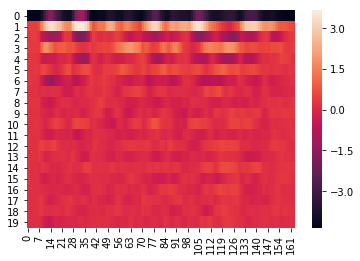

In [16]:
sns.heatmap(df.MFCC.values[0])

In [20]:
from sklearn.cluster import MiniBatchKMeans

k_means = MiniBatchKMeans(n_clusters=10)
    
X = np.concatenate(df.MFCC,axis=1).T
X[np.isnan(X)] = 0
k_means.fit(X)

df['cluster_vec'] = df.MFCC.apply(lambda x: np.eye(100)[k_means.predict(x.T)]) 
df['cluster'] = df.MFCC.apply(lambda x: k_means.predict(x.T))
df['label'] = df.apply(lambda x: [x.emotion]*x.length,axis=1)
df.head()

,recognized,natural,sex,age,speaker,emotion,MFCC,length,clusters,label,cluster_vec,cluster
Satz,,,,,,,,,,,,
03a01Fa,90,75,m,31,03,happiness,"[[-567.6825147990252, -581.654191099738, -586....",82,"[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[happiness, happiness, happiness, happiness, h...","[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1, 1, 1, 1, 8, 0, 4, 4, 4, 4, 6, 8, 8, 8, 6, ..."
03a01Nc,100,95,m,31,03,neutral,"[[-533.0046075163939, -523.9818990959373, -542...",70,"[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[neutral, neutral, neutral, neutral, neutral, ...","[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1, 1, 1, 1, 8, 6, 4, 4, 4, 4, 4, 4, 4, 6, 2, ..."
03a01Wa,95,90,m,31,03,anger,"[[-542.0457748127102, -541.8060849373669, -541...",81,"[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[anger, anger, anger, anger, anger, anger, ang...","[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1, 1, 1, 1, 1, 8, 4, 4, 3, 4, 4, 0, 0, 4, 3, ..."
08a01Ab,85,55,f,34,08,fear,"[[-535.9774832996947, -511.03487434141783, -51...",80,"[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[fear, fear, fear, fear, fear, fear, fear, fea...","[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1, 1, 1, 2, 0, 0, 4, 4, 0, 0, 0, 4, 3, 3, 3, ..."
08a01Fd,90,50,f,34,08,happiness,"[[-454.30345984732406, -455.7445815900608, -45...",100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[happiness, happiness, happiness, happiness, h...","[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [49]:
X = np.concatenate(df[df.emotion == 'happiness'].cluster_vec)
y = np.concatenate(df[df.emotion == 'happiness'].label)
lengths = df[df.emotion == 'happiness'].length
print(len(X),len(y),len(lengths))

7817 7817 71


In [51]:
markov = hmm.GMMHMM(n_components=3,n_iter=1000).fit(X,lengths)

idx = 4
X_test = df.cluster.values[idx]
y_test = df.emotion[idx]
print(y_test)
markov.predict_proba(X_test.reshape(-1,1)).mean()

/Users/flemming/miniconda3/envs/affect_recognition/lib/python3.7/site-packages/hmmlearn/stats.py:47: RuntimeWarning: divide by zero encountered in log
  + np.dot(X ** 2, (1.0 / covars).T))
/Users/flemming/miniconda3/envs/affect_recognition/lib/python3.7/site-packages/hmmlearn/stats.py:47: RuntimeWarning: invalid value encountered in true_divide
  + np.dot(X ** 2, (1.0 / covars).T))
/Users/flemming/miniconda3/envs/affect_recognition/lib/python3.7/site-packages/hmmlearn/stats.py:47: RuntimeWarning: divide by zero encountered in true_divide
  + np.dot(X ** 2, (1.0 / covars).T))
/Users/flemming/miniconda3/envs/affect_recognition/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


happiness


ValueError: startprob_ must sum to 1.0 (got nan)

In [70]:
np.exp(markov.score(df.MFCC.values[0].T))

0.0